# CNN trained on local data

## Adapted from DSCI 572 Lab 4

In [61]:
import numpy as np
import pandas as pd
import os

from sklearn.model_selection import train_test_split
from scipy.signal import convolve2d

from skimage.io import imread
import re
import matplotlib.pyplot as plt
%matplotlib inline
import time
import os
import json
from collections import defaultdict
from tqdm import tqdm
import pickle
from time import time
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from itertools import chain
from skimage.color import rgb2gray
from skimage.transform import resize

import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras import utils
from tensorflow.keras.applications import vgg16, inception_v3, resnet50, mobilenet, nasnet

In [5]:
plt.rcParams['font.size'] = 16

## Getting image paths and labels

In [6]:
root_captioning = "../s3"

In [7]:
def get_img_info(name, num=np.inf):
    """
    Returns img paths and captions

    Parameters:
    -----------
    name: str
        the json file name
    num: int (default: np.inf)
        the number of observations to get

    Return:
    --------
    list, dict, int
        img paths, corresponding captions, max length of captions
    """
    img_path = []
    caption = [] 
    max_length = 0
    with open(f'{root_captioning}/json/{name}.json', 'r') as json_data:
        data = json.load(json_data)
        for filename in data.keys():
            if num is not None and len(caption) == num:
                break
            img_path.append(
                f'{root_captioning}/{name}/{filename}'
            )
            sen_list = []
            for sentence in data[filename]['sentences']:
                max_length = max(max_length, len(sentence['tokens']))
                sen_list.append(sentence['raw'])

            caption.append(sen_list)
    
    return img_path, caption, max_length            


In [8]:
train_paths, train_descriptions, max_length_train = get_img_info('train')
test_paths, test_descriptions, max_length_test = get_img_info('valid')

In [9]:
train_paths[1]

'../s3/train/rsicd_denseresidential_363.jpg'

In [10]:
class_train_paths = []
class_train_classes = []
for i in range(0, len(train_paths)):
    matches = re.findall("rsicd_[a-z]+", train_paths[i])
    if len(matches) == 1:
        class_train_classes.append(matches[0][6:])
        class_train_paths.append(train_paths[i])

In [11]:
class_test_paths = []
class_test_classes = []
for i in range(0, len(test_paths)):
    matches = re.findall("rsicd_[a-z]+", test_paths[i])
    if len(matches) == 1:
        class_test_classes.append(matches[0][6:])
        class_test_paths.append(test_paths[i])

In [12]:
print(len(class_train_classes))
print(len(set(class_train_classes)))

6384
30


In [13]:
labels = set(class_train_classes)
labels

{'airport',
 'bareland',
 'baseballfield',
 'beach',
 'bridge',
 'center',
 'church',
 'commercial',
 'denseresidential',
 'desert',
 'farmland',
 'forest',
 'industrial',
 'meadow',
 'mediumresidential',
 'mountain',
 'park',
 'parking',
 'playground',
 'pond',
 'port',
 'railwaystation',
 'resort',
 'river',
 'school',
 'sparseresidential',
 'square',
 'stadium',
 'storagetanks',
 'viaduct'}

In [14]:
d = dict()
i = 0
for label in labels:
    if label not in d:
        d[label] = i
        i += 1
print(d)

{'farmland': 0, 'bareland': 1, 'denseresidential': 2, 'playground': 3, 'commercial': 4, 'meadow': 5, 'railwaystation': 6, 'resort': 7, 'church': 8, 'baseballfield': 9, 'beach': 10, 'sparseresidential': 11, 'school': 12, 'pond': 13, 'parking': 14, 'forest': 15, 'airport': 16, 'mountain': 17, 'port': 18, 'desert': 19, 'storagetanks': 20, 'mediumresidential': 21, 'stadium': 22, 'bridge': 23, 'viaduct': 24, 'center': 25, 'river': 26, 'square': 27, 'industrial': 28, 'park': 29}


In [15]:
for label in labels:
    print(class_train_classes.count(label)/len(class_train_classes))

0.03540100250626566
0.029918546365914785
0.03869047619047619
0.03837719298245614
0.03587092731829574
0.02819548872180451
0.02725563909774436
0.02976190476190476
0.024279448621553883
0.022243107769423558
0.040413533834586464
0.028665413533834585
0.02882205513784461
0.04088345864661654
0.03712406015037594
0.02506265664160401
0.03649749373433584
0.03634085213032581
0.039160401002506263
0.029918546365914785
0.03446115288220551
0.030858395989974936
0.028352130325814535
0.03712406015037594
0.041979949874686714
0.02568922305764411
0.040726817042606514
0.03305137844611529
0.039160401002506263
0.03571428571428571


In [16]:
for label in labels:
    print(class_test_classes.count(label)/len(class_test_classes))

0.04735202492211838
0.0367601246105919
0.04672897196261682
0.037383177570093455
0.030529595015576325
0.03177570093457944
0.024922118380062305
0.02554517133956386
0.019314641744548288
0.02118380062305296
0.03426791277258567
0.028037383177570093
0.03489096573208723
0.04299065420560748
0.03426791277258567
0.024922118380062305
0.032398753894081
0.028037383177570093
0.040498442367601244
0.03489096573208723
0.040498442367601244
0.028037383177570093
0.028037383177570093
0.030529595015576325
0.040498442367601244
0.024922118380062305
0.041744548286604365
0.03613707165109034
0.041744548286604365
0.03115264797507788


> The occurances of all the classes in both the train and validation fall between 2 and 5%, so the dataset is fairly balanced and shouldn't skew the results of the model too much.

## Training baseline model with 1 color channel

In [17]:
train_img = []
y_train = []
train_length = len(class_train_paths)
for i in range(0, train_length):
    # defining the image path
    image_path = class_train_paths[i]
    # reading the image
    img = imread(image_path, as_gray=True)
    # normalizing the pixel values
    img /= 255.0
    # converting the type of pixel to float 32
    img = img.astype('float32')
    # appending the image into the list
    train_img.append(img)
    y_train.append(class_train_classes[i])
    
# converting the list to numpy array
X_train = np.array(train_img)
# defining the target
X_train.shape
y_train = np.array(y_train)
for i in range(0, len(y_train)):
    y_train[i] = d[y_train[i]]
y_train = y_train.astype(int);
print(X_train.shape)

(6384, 299, 299)


In [18]:
test_img = []
y_test = []
test_length = len(class_test_paths)
for i in range(0, test_length):
    # defining the image path
    image_path = class_test_paths[i]
    # reading the image
    img = imread(image_path, as_gray=True)
    # normalizing the pixel values
    img /= 255.0
    # converting the type of pixel to float 32
    img = img.astype('float32')
    # appending the image into the list
    test_img.append(img)
    y_test.append(class_test_classes[i])
    
# converting the list to numpy array
X_test = np.array(test_img)
# defining the target
X_test.shape
y_test = np.array(y_test)
for i in range(0, len(y_test)):
    y_test[i] = d[y_test[i]]
y_test = y_test.astype(int)
print(X_test.shape)

(1605, 299, 299)


In [19]:
# reshape to be [samples][channels][width][height]
X_train = X_train.reshape(X_train.shape[0], 299, 299, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 299, 299, 1).astype('float32')

# one hot encode outputs
y_train = utils.to_categorical(y_train)
y_test = utils.to_categorical(y_test)
num_classes = y_test.shape[1]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(num_classes)

(6384, 299, 299, 1)
(6384, 30)
(1605, 299, 299, 1)
(1605, 30)
30


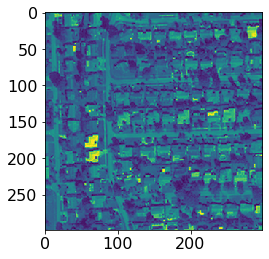

In [20]:
plt.imshow(X_train[0].reshape([299,299]))

In [21]:
# define a simple CNN model
def build_mnist_CNN():
    mnist_model = Sequential()
    mnist_model.add(Conv2D(32, (5, 5), input_shape=(299, 299, 1), activation='relu'))
    mnist_model.add(MaxPooling2D(pool_size=(2, 2)))
    mnist_model.add(Dropout(0.2))
    mnist_model.add(Flatten())
    mnist_model.add(Dense(128, activation='relu'))
    mnist_model.add(Dense(num_classes, activation='softmax'))

    # Compile model
    mnist_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return mnist_model

In [22]:
mnist_model = build_mnist_CNN()

In [23]:
# Fit the model
mnist_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=256)
# Final evaluation of the model
scores = mnist_model.evaluate(X_test, y_test, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

Epoch 1/10
25/25 [==============================] - 4s 176ms/step - loss: 3.3610 - accuracy: 0.0462 - val_loss: 3.2625 - val_accuracy: 0.0785
Epoch 2/10
25/25 [==============================] - 4s 149ms/step - loss: 3.1674 - accuracy: 0.0898 - val_loss: 3.0870 - val_accuracy: 0.1022
Epoch 3/10
25/25 [==============================] - 4s 150ms/step - loss: 3.0373 - accuracy: 0.1223 - val_loss: 3.0116 - val_accuracy: 0.1321
Epoch 4/10
25/25 [==============================] - 4s 150ms/step - loss: 2.9708 - accuracy: 0.1505 - val_loss: 2.9525 - val_accuracy: 0.1576
Epoch 5/10
25/25 [==============================] - 4s 150ms/step - loss: 2.8992 - accuracy: 0.1767 - val_loss: 2.9151 - val_accuracy: 0.1676
Epoch 6/10
25/25 [==============================] - 4s 150ms/step - loss: 2.8536 - accuracy: 0.1891 - val_loss: 2.8773 - val_accuracy: 0.1844
Epoch 7/10
25/25 [==============================] - 4s 149ms/step - loss: 2.8129 - accuracy: 0.2047 - val_loss: 2.8558 - val_accuracy: 0.1869
Epoch 

> With 30 different classes, the validation accuracy of 0.19 is not too bad.

## Training baseline model with all 3 colour channels

In [24]:
train_img = []
y_train = []
train_length = len(class_train_paths)
for i in range(0, train_length):
    # defining the image path
    image_path = class_train_paths[i]
    # reading the image
    img = imread(image_path)
    # converting the type of pixel to float 32 and normalizing
    img = img.astype('float32')/255.0
    # appending the image into the list
    train_img.append(img)
    y_train.append(class_train_classes[i])
    
# converting the list to numpy array
X_train = np.array(train_img)
# defining the target
X_train.shape
y_train = np.array(y_train)
for i in range(0, len(y_train)):
    y_train[i] = d[y_train[i]]
y_train = y_train.astype(int);
print(X_train.shape)
y_train

(6384, 299, 299, 3)


array([ 2,  7,  9, ..., 19, 28, 26])

In [25]:
test_img = []
y_test = []
test_length = len(class_test_paths)
for i in range(0, test_length):
    # defining the image path
    image_path = class_test_paths[i]
    # reading the image
    img = imread(image_path)
    # converting the type of pixel to float 32 and normalizing
    img = img.astype('float32')/255.0
    # appending the image into the list
    test_img.append(img)
    y_test.append(class_test_classes[i])
    
# converting the list to numpy array
X_test = np.array(test_img)
# defining the target
X_test.shape
y_test = np.array(y_test)
for i in range(0, len(y_test)):
    y_test[i] = d[y_test[i]]
y_test = y_test.astype(int)
print(X_test.shape)
y_test

(1605, 299, 299, 3)


array([29, 17,  2, ..., 26, 17, 29])

In [26]:
# reshape to be [samples][channels][width][height]
X_train = X_train.reshape(X_train.shape[0], 299, 299, 3).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 299, 299, 3).astype('float32')

# one hot encode outputs
y_train = utils.to_categorical(y_train)
y_test = utils.to_categorical(y_test)
num_classes = y_test.shape[1]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(num_classes)

(6384, 299, 299, 3)
(6384, 30)
(1605, 299, 299, 3)
(1605, 30)
30


In [27]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(299, 299, 3)))
model.add(Activation('relu')) # this is just different syntax for specifying the activation function
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 297, 297, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 297, 297, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 148, 148, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 146, 146, 32)      9248      
_________________________________________________________________
activation_1 (Activation)    (None, 146, 146, 32)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 71, 71, 64)       

In [28]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10)

Epoch 1/10
200/200 [==============================] - 8s 38ms/step - loss: 3.2254 - accuracy: 0.0876 - val_loss: 2.7947 - val_accuracy: 0.2037
Epoch 2/10
200/200 [==============================] - 7s 36ms/step - loss: 2.8973 - accuracy: 0.1429 - val_loss: 2.4691 - val_accuracy: 0.2386
Epoch 3/10
200/200 [==============================] - 7s 36ms/step - loss: 2.7150 - accuracy: 0.1717 - val_loss: 2.3237 - val_accuracy: 0.3190
Epoch 4/10
200/200 [==============================] - 7s 36ms/step - loss: 2.5745 - accuracy: 0.2032 - val_loss: 2.1481 - val_accuracy: 0.3651
Epoch 5/10
200/200 [==============================] - 7s 36ms/step - loss: 2.4655 - accuracy: 0.2292 - val_loss: 2.1092 - val_accuracy: 0.3657
Epoch 6/10
200/200 [==============================] - 8s 38ms/step - loss: 2.3472 - accuracy: 0.2533 - val_loss: 2.0586 - val_accuracy: 0.3969
Epoch 7/10
200/200 [==============================] - 7s 37ms/step - loss: 2.2624 - accuracy: 0.2682 - val_loss: 2.0339 - val_accuracy: 0.4056

> With the full colour images and a more advanced CNN model we can achieve almost 50% accuracy, which is pretty good.

## Transfer learning with InceptionV3

In [29]:
# Get the InceptionV3 model trained on the ImageNet data set
base_inception = inception_v3.InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

87916544/87910968 [==============================] - 3s 0us/step


In [30]:
top_block = base_inception.output
top_block = GlobalAveragePooling2D()(top_block) # pool over height/width to reduce number of parameters
top_block = Dense(256, activation='relu')(top_block) # add a Dense layer
predictions = Dense(num_classes, activation='softmax')(top_block) # add another Dense layer

model_transfer = Model(inputs=base_inception.input, outputs=predictions)

In [31]:
for layer in base_inception.layers:
    layer.trainable = False

In [32]:
model_transfer.compile(Adam(lr=.001), loss='categorical_crossentropy', metrics=['accuracy']) 
model_transfer.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d_4[0][0]                   
__________________________________________________________________________________________________
activation_5 (Activation)       (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [33]:
model_transfer.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10)

Epoch 1/10
200/200 [==============================] - 15s 75ms/step - loss: 1.1439 - accuracy: 0.6758 - val_loss: 0.6823 - val_accuracy: 0.8006
Epoch 2/10
200/200 [==============================] - 13s 64ms/step - loss: 0.4577 - accuracy: 0.8643 - val_loss: 0.5445 - val_accuracy: 0.8424
Epoch 3/10
200/200 [==============================] - 13s 63ms/step - loss: 0.2933 - accuracy: 0.9110 - val_loss: 0.4710 - val_accuracy: 0.8548
Epoch 4/10
200/200 [==============================] - 13s 63ms/step - loss: 0.2270 - accuracy: 0.9319 - val_loss: 0.4396 - val_accuracy: 0.8542
Epoch 5/10
200/200 [==============================] - 13s 64ms/step - loss: 0.1655 - accuracy: 0.9503 - val_loss: 0.4017 - val_accuracy: 0.8692
Epoch 6/10
200/200 [==============================] - 13s 63ms/step - loss: 0.1240 - accuracy: 0.9648 - val_loss: 0.4339 - val_accuracy: 0.8617
Epoch 7/10
200/200 [==============================] - 13s 63ms/step - loss: 0.0962 - accuracy: 0.9721 - val_loss: 0.4874 - val_accuracy:

> This basic model utilizing a pretrained model gets an accuracy of 87% which is much better than our model from scratch.

In [34]:
for i, layer in enumerate(reversed(model_transfer.layers)):
    layer.trainable = True
#     print(layer)
    if i > 15:
        break

# compile the model with a SGD/momentum optimizer and a very slow learning rate.
model_transfer.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

In [35]:
model_transfer.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10)

Epoch 1/10
200/200 [==============================] - 14s 71ms/step - loss: 0.0503 - accuracy: 0.9912 - val_loss: 0.3920 - val_accuracy: 0.8766
Epoch 2/10
200/200 [==============================] - 13s 64ms/step - loss: 0.0328 - accuracy: 0.9980 - val_loss: 0.3846 - val_accuracy: 0.8779
Epoch 3/10
200/200 [==============================] - 13s 64ms/step - loss: 0.0293 - accuracy: 0.9987 - val_loss: 0.3783 - val_accuracy: 0.8810
Epoch 4/10
200/200 [==============================] - 13s 64ms/step - loss: 0.0272 - accuracy: 0.9986 - val_loss: 0.3750 - val_accuracy: 0.8822
Epoch 5/10
200/200 [==============================] - 13s 65ms/step - loss: 0.0256 - accuracy: 0.9986 - val_loss: 0.3736 - val_accuracy: 0.8829
Epoch 6/10
200/200 [==============================] - 13s 64ms/step - loss: 0.0245 - accuracy: 0.9989 - val_loss: 0.3711 - val_accuracy: 0.8835
Epoch 7/10
200/200 [==============================] - 13s 64ms/step - loss: 0.0234 - accuracy: 0.9992 - val_loss: 0.3714 - val_accuracy:

> By unfreezing the last 15 layers of the model it becomes more flexible and we achieved a slightly better result using this model.

> Overall using transfer learning is much more effective than training a model from scratch.

## Transfer Learning with VGG16

In [36]:
base_VGG16 = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

58892288/58889256 [==============================] - 8s 0us/step


In [37]:
top_block = base_VGG16.output
top_block = GlobalAveragePooling2D()(top_block) # pool over height/width to reduce number of parameters
top_block = Dense(256, activation='relu')(top_block) # add a Dense layer
predictions = Dense(num_classes, activation='softmax')(top_block) # add another Dense layer

model_transfer = Model(inputs=base_VGG16.input, outputs=predictions)

In [38]:
for layer in base_VGG16.layers:
    layer.trainable = False

In [39]:
model_transfer.compile(Adam(lr=.001), loss='categorical_crossentropy', metrics=['accuracy']) 

In [40]:
model_transfer.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10)

Epoch 1/10
200/200 [==============================] - 26s 128ms/step - loss: 2.2263 - accuracy: 0.4187 - val_loss: 1.4843 - val_accuracy: 0.6006
Epoch 2/10
200/200 [==============================] - 24s 122ms/step - loss: 1.2718 - accuracy: 0.6436 - val_loss: 1.1184 - val_accuracy: 0.6654
Epoch 3/10
200/200 [==============================] - 24s 122ms/step - loss: 1.0169 - accuracy: 0.7068 - val_loss: 1.0197 - val_accuracy: 0.6860
Epoch 4/10
200/200 [==============================] - 24s 122ms/step - loss: 0.8875 - accuracy: 0.7390 - val_loss: 0.8458 - val_accuracy: 0.7483
Epoch 5/10
200/200 [==============================] - 24s 122ms/step - loss: 0.7874 - accuracy: 0.7672 - val_loss: 0.7889 - val_accuracy: 0.7601
Epoch 6/10
200/200 [==============================] - 24s 122ms/step - loss: 0.7153 - accuracy: 0.7846 - val_loss: 0.7546 - val_accuracy: 0.7695
Epoch 7/10
200/200 [==============================] - 24s 122ms/step - loss: 0.6679 - accuracy: 0.7984 - val_loss: 0.7107 - val_ac

> This performs somewhat worse than the baseline InceptionV3 model, with a 79% accuracy on the validation set compared to 87%.

## Transfer Learning with ResNet

In [52]:
base_resnet = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

In [53]:
top_block = base_resnet.output
top_block = GlobalAveragePooling2D()(top_block) # pool over height/width to reduce number of parameters
top_block = Dense(256, activation='relu')(top_block) # add a Dense layer
predictions = Dense(num_classes, activation='softmax')(top_block) # add another Dense layer

model_transfer = Model(inputs=base_resnet.input, outputs=predictions)

In [54]:
for layer in base_resnet.layers:
    layer.trainable = False

In [55]:
model_transfer.compile(Adam(lr=.001), loss='categorical_crossentropy', metrics=['accuracy']) 

In [56]:
model_transfer.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10)

Epoch 1/10
200/200 [==============================] - 17s 83ms/step - loss: 3.3236 - accuracy: 0.0622 - val_loss: 3.1393 - val_accuracy: 0.1190
Epoch 2/10
200/200 [==============================] - 16s 79ms/step - loss: 3.0659 - accuracy: 0.0960 - val_loss: 2.9621 - val_accuracy: 0.1040
Epoch 3/10
200/200 [==============================] - 16s 79ms/step - loss: 2.9163 - accuracy: 0.1310 - val_loss: 2.8239 - val_accuracy: 0.1601
Epoch 4/10
200/200 [==============================] - 16s 79ms/step - loss: 2.7912 - accuracy: 0.1745 - val_loss: 2.7159 - val_accuracy: 0.2262
Epoch 5/10
200/200 [==============================] - 16s 80ms/step - loss: 2.6777 - accuracy: 0.2047 - val_loss: 2.6378 - val_accuracy: 0.1938
Epoch 6/10
200/200 [==============================] - 16s 79ms/step - loss: 2.5958 - accuracy: 0.2257 - val_loss: 2.5403 - val_accuracy: 0.2355
Epoch 7/10
200/200 [==============================] - 16s 79ms/step - loss: 2.5300 - accuracy: 0.2398 - val_loss: 2.4707 - val_accuracy:

> This is terrible. Maybe something went wrong with model creation.

## Transfer Learning with NASNetLarge

In [70]:
base_nasnet = nasnet.NASNetLarge(weights='imagenet', include_top=False)

In [71]:
top_block = base_nasnet.output
top_block = GlobalAveragePooling2D()(top_block) # pool over height/width to reduce number of parameters
top_block = Dense(256, activation='relu')(top_block) # add a Dense layer
predictions = Dense(num_classes, activation='softmax')(top_block) # add another Dense layer

model_transfer = Model(inputs=base_nasnet.input, outputs=predictions)

In [72]:
for layer in base_nasnet.layers:
    layer.trainable = False

In [73]:
model_transfer.compile(Adam(lr=.001), loss='categorical_crossentropy', metrics=['accuracy']) 

In [74]:
model_transfer.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10)

Epoch 1/10
200/200 [==============================] - 61s 304ms/step - loss: 0.9853 - accuracy: 0.7165 - val_loss: 0.6986 - val_accuracy: 0.8031
Epoch 2/10
200/200 [==============================] - 55s 273ms/step - loss: 0.3633 - accuracy: 0.8841 - val_loss: 0.6321 - val_accuracy: 0.8069
Epoch 3/10
200/200 [==============================] - 55s 274ms/step - loss: 0.2118 - accuracy: 0.9328 - val_loss: 0.6151 - val_accuracy: 0.8224
Epoch 4/10
200/200 [==============================] - 55s 274ms/step - loss: 0.1292 - accuracy: 0.9641 - val_loss: 0.5616 - val_accuracy: 0.8380
Epoch 5/10
200/200 [==============================] - 55s 274ms/step - loss: 0.0848 - accuracy: 0.9771 - val_loss: 0.5718 - val_accuracy: 0.8411
Epoch 6/10
200/200 [==============================] - 55s 275ms/step - loss: 0.0509 - accuracy: 0.9887 - val_loss: 0.5263 - val_accuracy: 0.8486
Epoch 7/10
200/200 [==============================] - 55s 274ms/step - loss: 0.0301 - accuracy: 0.9945 - val_loss: 0.5711 - val_ac

> This performs similarly to the InceptionV3 model.